### Workflow:

- Before start:
    - Add files
    - Combine all files
    - import libraries
- Experiment:
    - EVERYTHING

# 1: Import libs and files

## Preprocessing

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# a = pd.read_csv('worldriskindex-datasets\worldriskindex-2000.csv')
# a.info()


a = pd.DataFrame()

link = 'worldriskindex-datasets\worldriskindex-'
for y in range(2000,2024):
    b = pd.read_csv(f"{link}{y}.csv")
    
    if ("Year" not in b.columns):
        b["Year"] = y

    if ("WRI.Country" in b.columns):
        b.rename(columns={'WRI.Country': 'Country'}, inplace=True)
        
    if ("ISO3.Code" in b.columns):
        b.rename(columns={'ISO3.Code': 'ISO3'}, inplace=True)
    
    a = pd.concat([a, b], axis=0)

# delete attr
a.drop(columns=["SI_10_Norm", "SI_10_Base", "SI_11_Norm"], inplace=True)
a.info(verbose=True)


<class 'pandas.core.frame.DataFrame'>
Index: 4632 entries, 0 to 192
Data columns (total 245 columns):
 #    Column       Dtype  
---   ------       -----  
 0    Country      object 
 1    ISO3         object 
 2    W            float64
 3    E            float64
 4    V            float64
 5    S            float64
 6    C            float64
 7    A            float64
 8    S_01         float64
 9    S_02         float64
 10   S_03         float64
 11   S_04         float64
 12   S_05         float64
 13   C_01         float64
 14   C_02         float64
 15   C_03         float64
 16   A_01         float64
 17   A_02         float64
 18   A_03         float64
 19   EI_01        float64
 20   EI_02        float64
 21   EI_03        float64
 22   EI_04        float64
 23   EI_05        float64
 24   EI_06        float64
 25   EI_07        float64
 26   SI_01        float64
 27   SI_02        float64
 28   SI_03        float64
 29   SI_04        float64
 30   SI_05        float64
 31   S

We find that there are inconsistency in columns
```
WRI.Country  > Rename Attr
ISO3.Code  > Rename Attr
Year  >  Add where missing
SI_10_Norm > Min-Max Norm
SI_10_Base > Min-Max Norm
SI_11_Norm > Min-Max Norm
```

In [52]:
COLUMNS = a.columns

## Description and Visualization

## Correlation Analysis

In [53]:
x = []
for c in COLUMNS:
    if "I" not in c:
        x.append(c)
data = a[x]

data.describe()

,W,E,V,S,C,A,S_01,S_02,S_03,S_04,S_05,C_01,C_02,C_03,A_01,A_02,A_03,Year
count,4632.000000,4632.000000,4632.000000,4632.000000,4632.000000,4632.000000,4632.000000,4632.000000,4632.000000,4632.000000,4632.000000,4632.000000,4632.000000,4632.000000,4632.000000,4632.000000,4632.000000,4632.000000
mean,8.093871,5.326598,23.821079,21.810149,19.038875,42.026218,48.224421,30.700257,48.356794,7.791412,48.367722,10.500097,49.514082,48.816839,48.580343,38.494439,47.461209,2011.500000
std,9.141849,10.050235,16.672180,17.183243,20.517906,17.892542,15.304850,25.125932,15.592063,16.339170,15.646773,19.897971,17.269909,17.421748,15.042478,21.915024,15.953295,6.922934
min,0.220000,0.020000,2.290000,1.660000,0.130000,2.200000,3.370000,0.060000,1.660000,0.010000,2.590000,0.010000,0.010000,1.980000,1.910000,0.410000,0.010000,2000.000000
25%,2.200000,0.240000,11.080000,8.537500,6.340000,28.997500,37.917500,3.780000,36.770000,0.160000,37.630000,0.400000,37.610000,36.430000,38.017500,25.505000,36.557500,2005.750000
50%,4.120000,1.050000,19.645000,16.150000,11.440000,43.685000,50.565000,34.640000,49.345000,0.655000,49.485000,0.605000,50.775000,48.645000,48.625000,38.225000,48.320000,2011.500000
75%,10.415000,5.230000,30.572500,30.630000,15.012500,56.445000,60.592500,52.172500,59.465000,2.830000,60.200000,0.830000,61.565000,62.620000,60.470000,55.540000,58.697500,2017.250000
max,47.240000,64.590000,76.220000,75.770000,86.480000,81.810000,77.340000,87.820000,88.930000,76.970000,82.550000,83.460000,100.000000,91.910000,83.400000,93.620000,100.000000,2023.000000


### Susceptibility

In [54]:
x = []
for c in data.columns:
    if "S" in c:
        x.append(c)
s = data[x]
s.head()

,S,S_01,S_02,S_03,S_04,S_05
0,61.91,65.90,70.66,70.10,59.38,46.92
1,12.58,53.08,15.47,36.27,2.05,5.17
2,30.07,48.02,35.44,43.51,8.87,37.41
3,2.58,33.23,0.54,30.52,0.01,20.96
4,35.52,59.61,64.24,81.51,2.59,69.93


In [55]:
susceptibility_corr_matrix = s.corr()

susceptibility_corr_matrix

,S,S_01,S_02,S_03,S_04,S_05
S,1.000000,0.664136,0.753832,0.684335,0.830989,0.631144
S_01,0.664136,1.000000,0.845375,0.739473,0.353432,0.735567
S_02,0.753832,0.845375,1.000000,0.776022,0.421426,0.789791
S_03,0.684335,0.739473,0.776022,1.000000,0.381145,0.716421
S_04,0.830989,0.353432,0.421426,0.381145,1.000000,0.308797
S_05,0.631144,0.735567,0.789791,0.716421,0.308797,1.000000


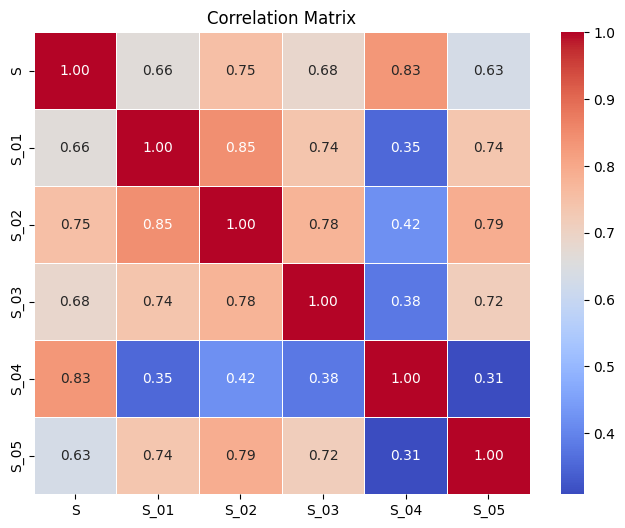

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(susceptibility_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix")
plt.show()

### C

In [62]:
y = []
for c in data.columns:
    if "C" in c:
        y.append(c)
c = data[y]
c = c.drop(columns=['Country'])
c.head()

,C,C_01,C_02,C_03
0,78.59,69.90,89.50,77.60
1,44.15,29.40,62.77,46.64
2,51.99,36.70,69.41,55.17
3,2.18,0.01,29.92,34.66
4,65.02,45.85,85.48,70.13


In [63]:
c_corr_matrix = c.corr()

c_corr_matrix

,C,C_01,C_02,C_03
C,1.000000,0.963432,0.602132,0.529816
C_01,0.963432,1.000000,0.469600,0.392442
C_02,0.602132,0.469600,1.000000,0.711648
C_03,0.529816,0.392442,0.711648,1.000000


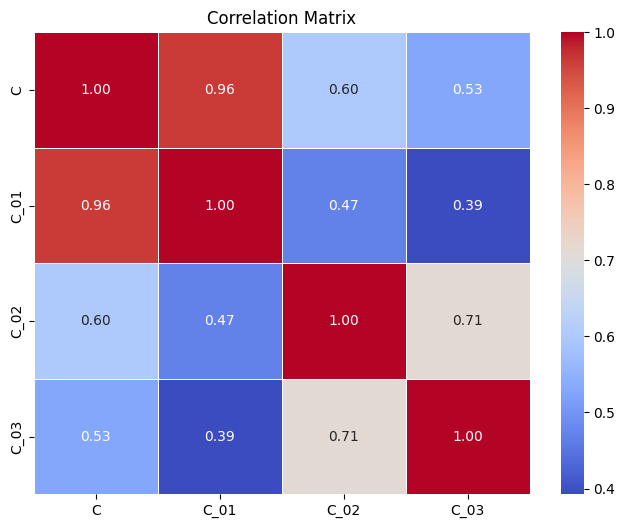

In [70]:
# Plot the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(c_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix")
plt.show()

### A

In [64]:
z = []
for c in data.columns:
    if "A" in c:
        z.append(c)
a = data[z]
a.head()

,A,A_01,A_02,A_03
0,71.47,66.56,84.53,64.89
1,10.40,51.86,30.98,0.70
2,40.76,54.28,45.20,27.60
3,25.10,24.23,16.69,39.11
4,76.41,72.17,85.22,72.54


In [65]:
a_corr_matrix = a.corr()

a_corr_matrix

,A,A_01,A_02,A_03
A,1.000000,0.788236,0.919855,0.725283
A_01,0.788236,1.000000,0.671813,0.588630
A_02,0.919855,0.671813,1.000000,0.493307
A_03,0.725283,0.588630,0.493307,1.000000


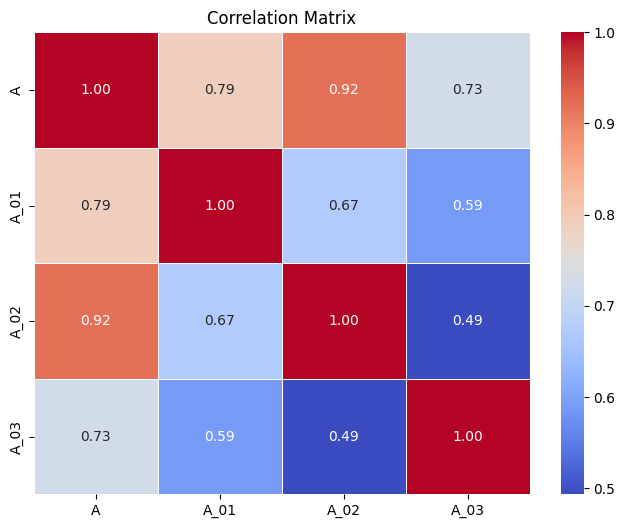

In [71]:
# Plot the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(a_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix")
plt.show()

# UNUSED CODES

In [57]:
x = ["Year"]

for c in a.columns:
    if ("SI_10" in c):
        x.append(c)

p = a[x]
p.head()

,Year,SI_10,SI_10a_Norm,SI_10a_Base,SI_10b_Norm,SI_10b_Base
0,2000,85.59,85.59,100.16,19.49,4.70
1,2000,46.49,46.26,48.45,58.17,11.27
2,2000,50.46,50.70,56.03,45.30,7.02
3,2000,23.60,34.58,30.85,60.57,14.65
4,2000,79.55,81.55,93.96,24.59,5.11


In [58]:
p.tail()

,Year,SI_10,SI_10a_Norm,SI_10a_Base,SI_10b_Norm,SI_10b_Base
188,2023,66.81,66.81,69.92,40.25,6.57
189,2023,33.89,46.02,32.82,54.46,12.74
190,2023,64.76,66.46,69.42,22.89,4.68
191,2023,71.32,73.91,78.66,11.44,3.16
192,2023,69.54,69.12,73.36,37.72,6.03


In [59]:
p.describe()

,Year,SI_10,SI_10a_Norm,SI_10a_Base,SI_10b_Norm,SI_10b_Base
count,4632.000000,4632.000000,4632.000000,4632.000000,4632.000000,4632.000000
mean,2011.500000,50.000047,49.910255,48.708178,50.000358,12.254644
std,6.922934,17.827748,17.864484,22.901600,17.826953,8.226182
min,2000.000000,0.010000,0.010000,14.920000,0.010000,0.800000
25%,2005.750000,38.010000,37.825000,28.190000,38.010000,5.990000
50%,2011.500000,50.000000,50.000000,43.950000,50.000000,8.930000
75%,2017.250000,61.990000,61.990000,67.450000,61.990000,17.832500
max,2023.000000,100.000000,100.000000,106.530000,100.000000,70.220000


In [60]:
#Calculating S10_Base
import pandas as pd
d = pd.read_csv('worldriskindex-datasets\worldriskindex-2000.csv')
#print(d.columns)

x = []

for c in d.columns:
    if ("SI_10" in c):
        x.append(c)
#print(d[x].shape)
year = pd.DataFrame({'Year': [2000] * 193})
s_2000 = pd.concat([year, d[x]],axis = 1)

#Creating S_10_Base

s_2000["SI_10_Base"] = s_2000["SI_10a_Base"] + s_2000["SI_10b_Base"]

 

# columns_to_normalize = ["SI_10a_Norm","SI_10b_Norm"]
# s_2000['SI_10_Norm'] = s_2000[columns_to_normalize].apply(min_max_normalize, axis=1)
# s_2000.head()

In [61]:
print("Help! Please\n :')")

Help! Please
 :')
